<a href="https://colab.research.google.com/github/TatyanaGreenkina/Research/blob/master/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import numpy as np
from gensim.models import Word2Vec
from tqdm import tqdm_notebook as tq
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load Data

In [3]:
with open(root_path+'Data/data.txt', 'r') as f:
  content = f.read()

data = [line.split('\n') for line in content.split('\n\n')][:-1]

dataset = []
for tweet in data:
  dataset.append(list(zip(*[pair.split(' ') for pair in tweet])))

tokens, tags = zip(*dataset)
tokens = [list(t) for t in tokens]
tags = [list(t) for t in tags]

print(tokens[:4])
print(tags[:4])

tags_set = set([j for i in tags for j in i])

labels_indicates = {ind: tag for ind, tag in zip(tags_set, range(1, len(tags_set) + 1))}
labels_indicates

[['\ufeffMan', 'i', 'hate', 'when', 'people', 'carry', 'ragedy', 'luggage', '..', 'ima', 'just', 'rip', 'it', 'up', 'more', 'with', 'the', 'belt', 'loader', '#itaintmines'], ['Men', "'s", 'soccer', 'vs', '.', 'Crown', 'College', 'at', 'home', 'tomorrow', 'at', '2', 'pm', '.', 'Come', 'support', 'your', 'Eagles', '!', 'Praying', 'for', 'you', 'guys', '!'], ['RT', '@koookieelatte', ':', 'pero', 'seryoso', 'may', 'schoolmate', 'ako', 'kamuka', 'nya', 'si', 'angel', 'omg', 'huhuu', 'ewan', 'pero', 'feeling', 'ko', 'sa', 'mata', 'sila', 'magkamuka', 'hahaa'], ["'RT", '@veganbotanicals', ':', 'alright', '#vegans', '!', 'ANY', 'purchase', 'from', 'our', 'etsy', 'shop', 'is', '1/2', 'off', 'when', 'you', 'type', '"', 'go', '#vegan', '"', 'in', 'the', 'message', 'to', 'seller', 'at', 'c', "...'"]]
[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'B-sportsteam', 'I-sportsteam', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

{'B-company': 15,
 'B-facility': 17,
 'B-geo-loc': 18,
 'B-movie': 11,
 'B-musicartist': 9,
 'B-other': 8,
 'B-person': 13,
 'B-product': 14,
 'B-sportsteam': 12,
 'B-tvshow': 4,
 'I-company': 1,
 'I-facility': 20,
 'I-geo-loc': 7,
 'I-movie': 10,
 'I-musicartist': 6,
 'I-other': 3,
 'I-person': 5,
 'I-product': 2,
 'I-sportsteam': 16,
 'I-tvshow': 19,
 'O': 21}

In [0]:
train_tokens = tokens[:int(len(tokens)*0.7)]
test_tokens = tokens[int(len(tokens)*0.7):]

train_tags = tags[:int(len(tags)*0.7)]
test_tags = tags[int(len(tags)*0.7):]

(array([106., 276., 655., 552., 573.,  57., 329., 164.,  81., 133.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <a list of 10 Patch objects>)

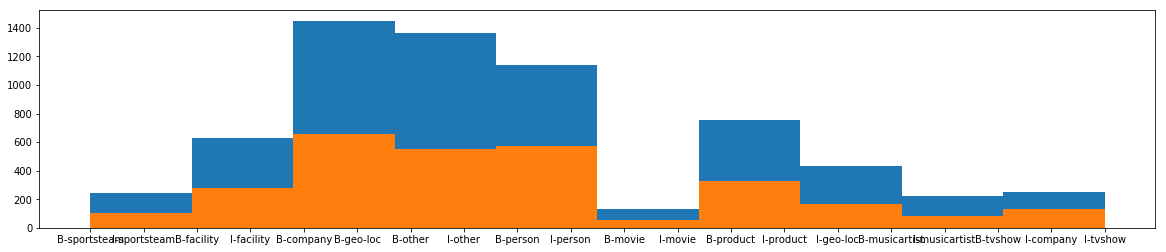

In [5]:
# Check distribution of tags in train and test sets
plt.figure(figsize=(20, 4))

train_tags_set = [j for i in train_tags for j in i if j != 'O']
plt.hist(train_tags_set)

test_tags_set = [j for i in test_tags for j in i if j != 'O']
plt.hist(test_tags_set)

### Train Word2Vec

In [0]:
model = Word2Vec(tokens, min_count=0) # dim = 100

### Build and train CNN

In [0]:
def masking_batch(batch):

# Function for masking data, this mask will stop backpropagation through paddings

  mask = np.zeros((len(batch), len(max(batch, key=len))))
  for ind, i in enumerate(batch):
    mask[ind][:len(i)] = np.ones_like(i)
  return mask

In [0]:
def get_emb(batch):

# Function returns batch[size_batch, num_tokens, embeddings_dimensions]

  emb = np.zeros((len(batch), len(max(batch, key=len)), 100))
  for ind_s, sent in enumerate(batch):
    for ind_w, word in enumerate(sent):
      emb[ind_s][ind_w] = model.wv[word]
  return emb

In [0]:
def get_labels(batch):

# Function returns labels_batch[size_batch, num_tokens] with tags indicators

  labels = np.zeros((len(batch), len(max(batch, key=len))))
  for ind, i in enumerate(batch):
    labels[ind][:len(i)] = [labels_indicates[word] for word in i]
  return labels

In [23]:
tf.reset_default_graph()

# placeholder for a tokens batch
token_ph = tf.placeholder(tf.float32, (None, None, 100)) 
# placeholder for a mask
mask_ph = tf.placeholder(tf.float32, (None, None))
# placeholder for a tags batch
tags_ph = tf.placeholder(tf.int32, (None, None)) 
# dropout
tokens_ph = tf.nn.dropout(token_ph, 0.7, (tf.shape(token_ph)[0], 1, tf.shape(token_ph)[2]))
# CNN layer
units = tf.layers.conv1d(token_ph, filters=128, kernel_size=7, padding='same')
#dropout
units = tf.nn.dropout(units, 0.7, (tf.shape(units)[0], 1, tf.shape(units)[2]))
# Fully connected layer
logits = tf.layers.dense(units, len(tags_set), activation=None) 
# Tensor with prediction tags
predictions = tf.argmax(logits, 2)

#Loss-function is cross-entropy, because there is a classification task (each token classifications from tags)
one_hot_labels = tf.one_hot(tags_ph, len(labels_indicates))
loss_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels,
                                                         logits=logits)
loss_tensor *= mask_ph
loss = tf.reduce_mean(loss_tensor)
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  loss_train_history = []
  loss_test_history = []
  # Nums epoch = 40
  for epoch in tq(range(5)):
    # Batch size = 32
    for step in range(0, len(train_tokens), 32):
      tokens_batch = train_tokens[step: step+32]
      tags_batch = train_tags[step: step+32]

      x = get_emb(tokens_batch)
      mask = masking_batch(tokens_batch)
      y_true = get_labels(tags_batch)
      feed_dict = {
          token_ph: x,
          mask_ph: mask,
          tags_ph: y_true
      }
      step_loss = sess.run(loss, feed_dict=feed_dict)
      loss_train_history.append(step_loss)
      
      x = get_emb(test_tokens)
      mask = masking_batch(test_tokens)
      y_true = get_labels(test_tags)
      feed_dict = {
            token_ph: x,
            mask_ph: mask,
            tags_ph: y_true
        }
      step_loss = sess.run(predictions, feed_dict=feed_dict)

      loss_test_history.append(step_loss)
    


0.14496065572653927

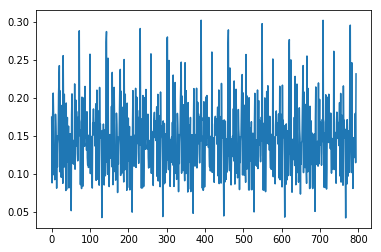

In [24]:
plt.plot(loss_train_history);
sum(loss_train_history)/len(loss_train_history)

### F1-score model

In [16]:
f_score = []
y_true_set = get_labels(test_tags)

for step_train_pred in tq(loss_test_history):
  for sample in range(len(y_true_set)):
    y_true = y_true_set[sample]
    y_pred = step_train_pred[sample]

    assert len(y_true) == len(y_pred)
    TP = 0
    FP = 0
    FN = 0
    for ind in range(len(y_true)):
      if y_true[ind] == y_pred[ind] and y_true[ind] != labels_indicates['O']:
        TP += 1
      if y_true[ind] == labels_indicates['O'] and y_pred[ind] != labels_indicates['O']:
        FP += 1
      if y_true[ind] != labels_indicates['O'] and y_pred[ind] == labels_indicates['O']:
        FN += 1

    if TP+FP == 0 or TP+FN == 0:
      f1_score = 0
    else:
      precision = TP/(TP+FP)
      recall = TP/(TP+FN)
      if precision != 0 or recall != 0:
        f1_score = (2*precision*recall)/(precision + recall)
      else:
        f1_score = 0
    f_score.append(f1_score)


In [22]:
sum(f_score)/len(f_score)

0.6857874849771307

Задача NER была решена обучением модели сверточной нейронной сети со средним значением ошики 0.14 на этапе тренировки и со средним значением метрики f1-score 0.68 на этапе валидации.